In [1]:
from matplotlib import pyplot as plot
from tqdm.notebook import tqdm
from itertools import product

from scipy.stats import gamma, norm, laplace
from random import sample
import numpy, ray, gc

%matplotlib inline

In [2]:
ray.init()

2019-12-06 21:03:22,252	WARNING worker.py:1268 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2019-12-06 21:03:22,260	INFO resource_spec.py:205 -- Starting Ray with 0.24 GiB memory available for workers and up to 0.14 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


{'node_ip_address': '192.168.42.2',
 'redis_address': '192.168.42.2:17796',
 'object_store_address': '/tmp/ray/session_2019-12-06_21-03-22_255498_22322/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2019-12-06_21-03-22_255498_22322/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2019-12-06_21-03-22_255498_22322'}

In [40]:
# Existing differentially-private schemes
def gaussian_noise(location, epsilon):
    return location + numpy.random.normal(loc = [0, 0], scale = 1 / epsilon )

def gaussian_conditional(location, conditional, epsilon):
    difference = numpy.array(location) - numpy.array(conditional)
    return numpy.prod( norm.pdf(difference, scale = 1 / epsilon) )

def laplacian_noise(location, epsilon):
    return location + numpy.random.laplace(loc = [0, 0], scale = 1 / epsilon )

def laplacian_conditional(location, conditional, epsilon):
    difference = numpy.array(location) - numpy.array(conditional)
    return numpy.prod( laplace.pdf(difference, scale = 1 / epsilon) )

def geo_noise(location, epsilon):
    theta, r = numpy.random.uniform(0, 2 * numpy.pi), gamma.ppf( numpy.random.uniform(0, 1), 2, scale = (1 / epsilon) )
    x, y = r * numpy.cos(theta), r * numpy.sin(theta)
    return location + numpy.array([x, y])

def geo_conditional(location, conditional, epsilon):
    x, y = numpy.array(location) - numpy.array(conditional)
    r = numpy.sqrt(x ** 2 + y ** 2)
    return gamma.pdf(r, 2, scale = 1 / epsilon) * (0.5 / numpy.pi)

# An extension of k-anonymity
def cloaking(location, epsilon):
    x, y = location
    return ( 5 * (x // 5), 5 * (y // 5) )

def cloaking_conditional(location, conditional, epsilon):
    return (1 / 25) if cloaking(conditional, epsilon) == location else 0

In [41]:
privacy_schemes = {
    "Gaussian": gaussian_noise,
    "Laplacian": laplacian_noise,
    
    "Geo-Indistinguishability": geo_noise,
    "Cloaking": cloaking
}

privacy_conditionals = {
    "Gaussian": gaussian_conditional,
    "Laplacian": laplacian_conditional,
    
    "Geo-Indistinguishability": geo_conditional,
    "Cloaking": cloaking_conditional
}

In [32]:
def distance(location, center):
    x, y = location
    a, b = center
    return numpy.sqrt( (x - a)**2 + (y - b)**2 )

def disjoint(x, y): 
    return 1 if (x < 10 and y > 10) or (x > 10 and y < 10) else 0

def transpose(nested):
    return list(zip(* nested))

In [33]:
class user:
    def __init__(self, server):
        self.space = server.space
        self.location_distr = self.centered_distribution()
        self.location_distr = self.location_distr / numpy.sum(self.location_distr)
        
    def centered_distribution(self):
        center  = self.space[ numpy.random.randint(0, len(self.space)) ]
        initial = [ numpy.random.uniform(0, 2) / (distance(L, center) + 1) for L in self.space ]
        return numpy.round( numpy.array( initial ) / numpy.sum( initial ), decimals = 3 )
        
    def sample(self, epochs):
        index = numpy.random.choice( len(self.space), size = epochs, p = self.location_distr )
        return [ self.space[i] for i in index ]

In [34]:
class server:
    def __init__(self, length = 75, count = 100, epochs = 250):
        self.space = product(range(length), repeat = 2 )
        self.space = list( map(tuple, self.space) )
        
        self.users = [ user(self) for i in tqdm(range(count)) ]
        self.length, self.epochs = length * length, epochs
        
        self.samples = [ u.sample(epochs) for u in tqdm(self.users) ]
        self.noisy_samples = {}
        
    def regularize_users(self, repetition):
        self.samples = [ s * repetition for s in self.samples ]
        self.epochs = self.epochs * repetition
        
    def average_difference(self, scheme):
        difference = 0
        for u, e in sample( list(product( range(len(self.users)), range(self.epochs) )), 1000 ):
            center, noisy_center = self.samples[u][e], self.noisy_samples["Geo-Indistinguishability"][u][e]
            difference = difference + self.disjuctive_size(scheme, center, noisy_center, e)
        return difference / 100
        
    def disjuctive_size(self, scheme, center, noisy_center, epoch):      
        locations = zip( transpose(self.samples)[epoch], transpose(self.noisy_samples[scheme])[epoch] )        
        disjunctive = [ disjoint( distance(x, center), distance(y, noisy_center) ) for x, y in locations ]
        return sum(disjunctive)
        
    def introduce_privacy(self, epsilon):
        self.epsilon = epsilon
        for scheme in tqdm(privacy_schemes):
            noise = privacy_schemes[ scheme ]
            
            heartbeats = [ self.noisy_user(u, noise) for u in self.samples ]            
            self.noisy_samples[ scheme ] = heartbeats
    
    def noisy_user(self, user, noise):
        return [ tuple(numpy.round( noise(location, self.epsilon) )) for location in user ]

In [35]:
class semi_honest(server):
    def average_predictive_power(self, scheme):
        results = [ self.noisy_estimates(scheme, i) for i in range(len(self.samples)) ]
        return numpy.mean( results, axis = 0 )
    
    def noisy_estimates(self, scheme, user):
        user_heartbeats = self.noisy_samples[scheme][user]
        estimates = [ numpy.array([ 1 if user_heartbeats[0] == x else 0 for x in self.space ]) ]

        for i in range(1, self.epochs):
            if user_heartbeats[i] in self.space:
                estimates.append( self.update_MLE(estimates[-1], user_heartbeats[i], i, scheme) )
            else:
                estimates.append( estimates[-1] )

        true = self.users[user].location_distr
        return numpy.fromiter( map( lambda x: self.bhattacharyya(x, true), estimates ), dtype = float )
        
    def update_MLE(self, distribution, heartbeat, epoch, scheme):
        conditional_probabilities = numpy.array([ privacy_conditionals[scheme](x, heartbeat, self.epsilon) for x in self.space ])

        previous = distribution * epoch
        current  = previous + conditional_probabilities
        return current / sum(current)
        
    def bhattacharyya(self, estimate, true):
        return numpy.sum(numpy.sqrt(estimate * true))

In [36]:
def compare_scheme_accuracy(server, save = False):
    endogenous = numpy.arange(0.025, 0.2525, 0.025)
    _exogenous = []
    
    for epsilon in tqdm(endogenous):
        server.introduce_privacy(epsilon)
        _exogenous.append([ server.average_difference(scheme) for scheme in privacy_schemes ])

    _exogenous = zip( transpose(_exogenous), privacy_schemes )
    for exogenous, scheme in _exogenous:
        plot.plot(endogenous, exogenous, label = scheme)

    plot.legend()
    plot.savefig(save) if save else plot.show()

In [37]:
def evaluate_privacy(server, scheme):
    return server.average_predictive_power(scheme), scheme

def compare_scheme_privacy(server, save = False):
    endogenous = range(server.epochs)
    _exogenous = [ evaluate_privacy(server, scheme) for scheme in privacy_schemes ]
    
    for exogenous, scheme in _exogenous:
        plot.plot(endogenous, exogenous, label = scheme)

    plot.legend()
    plot.savefig(save) if save else plot.show()

In [38]:
USGS = semi_honest(length = 10, count = 10, epochs = 250)
# USGS.regularize_users(100)

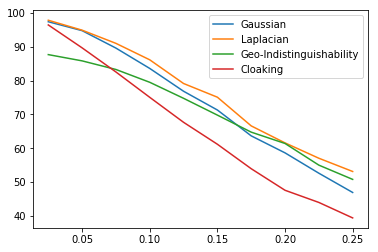

In [14]:
compare_scheme_accuracy(USGS)

In [15]:
USGS.epochs

250

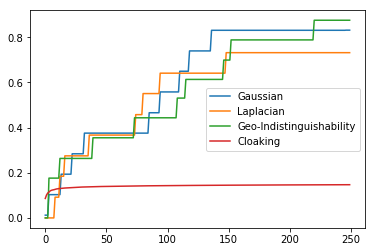

In [43]:
USGS.introduce_privacy(0.025)
compare_scheme_privacy(USGS)